In [148]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os
import cv2
from com import *
from skeleton import *
import pandas as pd

# ragular treatment

正常去背並且抓出位置，特別把位置定位在第二個sk。
這樣可以更精確地知道有多靠牆

In [2]:
imgspath = r"/home/isis0517/temp_data/free"
def getkey(x):
    temp = x.split("_")
    s = int(temp[-1].split(".")[0])
    return (temp[0], s)

flist = os.listdir(imgspath)
flist.sort(key=lambda x: (x[0:2], len(x), x))
print(len(flist))
data_len = len(flist)

60000


(1000, 1500)


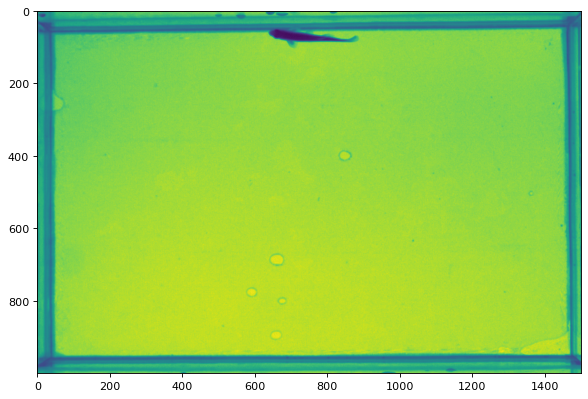

In [3]:
num = np.random.randint(data_len)
test_frame = np.load(os.path.join(imgspath, flist[num]))
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(test_frame)
print(test_frame.shape)

In [4]:
tnum = np.random.randint(data_len,size = data_len//10)
a = np.load(os.path.join(imgspath, flist[10]))
background = np.zeros(a.shape)
for s in tnum:
    a = np.load(os.path.join(imgspath, flist[s]))
    a = cv2.blur(a, ksize=(3, 3))
    background += a
background = background/len(tnum)
background = background.astype('uint8')


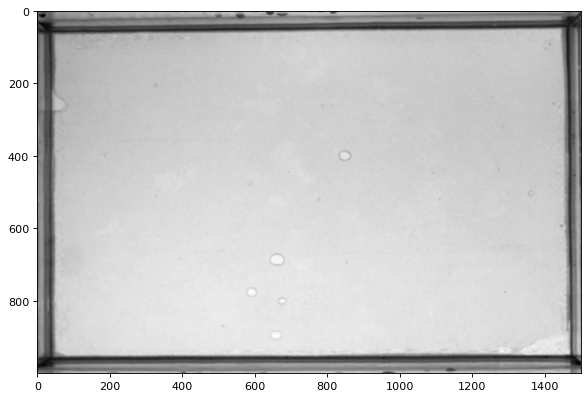

In [5]:
mask = np.full(background.shape, False)
mask[:,:] = True
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(background*mask, plt.cm.gray)

## output as video

In [6]:

cv2_shape = (background.shape[1]//3, background.shape[0]//3)
cv2_shape = (int(cv2_shape[0]), int(cv2_shape[1]))

video = cv2.VideoWriter("free_swim.avi", cv2.VideoWriter_fourcc(*"MJPG"), 20, cv2_shape, False)

for s in tqdm(range(data_len)):
    img = np.load(os.path.join(imgspath, flist[s]))
    video.write(cv2.resize(img, cv2_shape))
    
video.release()

  0%|          | 0/60000 [00:00<?, ?it/s]

In [22]:
%%time
from multiprocessing import Pool
from numba import jit, njit

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

abs_lim = 65
def multi_rot_imgs(filename, background, mask, abs_lim):
    size = 120
    img = np.load(filename)
    img = cv2.absdiff(img, background)
    img = img*mask
    img = np.where(img>abs_lim, 255, 0).astype('uint8')
    pos = get_pos(img)
    img = cutting_img(img, pos, size)
    
    try:
        sk = NT_skeleton(img)
        h_pos = sk[1]+np.array(pos)-np.array([120,120])
    except Exception as e:
        print(s, e)
        return 0
    
    v1 = sk[0]-sk[1]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    
    err = b-np.dot(get_rot_M(-angle), a) 
    b_len = np.linalg.norm(b)
    while np.linalg.norm(err) > b_len*0.1:
        angle=-angle
        err = b-np.dot(get_rot_M(-angle), a)
        
    if angle != angle:
        print("算錯啦")
        print(sk)
        
    M = cv2.getRotationMatrix2D((size, size), -angle/(np.pi)*180, 1)
    rotated = cv2.warpAffine(img, M, (2*size+1,2*size+1))
    
    return rotated, angle, pos, h_pos  


with Pool() as pool:
    map_arr = []
    for s in range(data_len):
        path = os.path.join(imgspath, flist[s])
        map_arr.append((path, background, mask, abs_lim))
    print("pool start")
    result = pool.starmap(multi_rot_imgs, map_arr)

imgs = []
h_ans = []
poses = []
h_poses = []

for temp in result:
    imgs.append(temp[0])
    h_ans.append(temp[1])
    poses.append(temp[2])
    h_poses.append(temp[3])

pool start
CPU times: user 4.26 s, sys: 3.92 s, total: 8.18 s
Wall time: 5min 45s


500


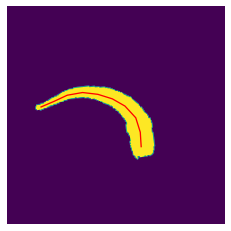

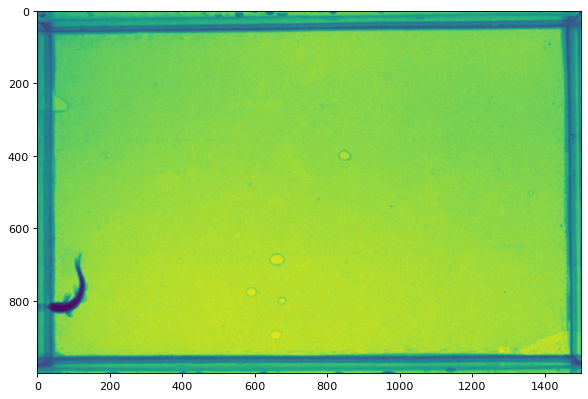

In [501]:
s = np.random.randint(data_len)
s = 500
sk = NT_skeleton(imgs[s])
print(s)
draw = imgs[s].copy()
for n in range(len(sk)-1):
    cv2.line(draw, (sk[n, 1], sk[n, 0]), (sk[n+1, 1], sk[n+1, 0]), (0), 1)
plt.imshow(imgs[s])
plt.plot(*np.flip(sk, axis=1).T, lw=1.3, color='r')
plt.axis('off')
#plt.imshow(np.load(os.path.join(imgspath, flist[s+data_len])))
plt.show()
plt.figure(figsize=(12, 6), dpi=80)
plt.imshow(np.load(os.path.join(imgspath, flist[s])))

(-1.0, 1.0)

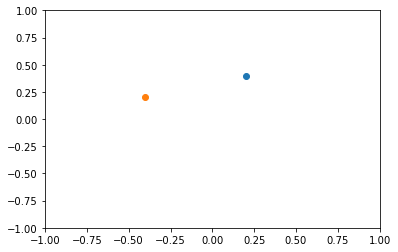

In [180]:
u = [0.2,0.4]
v = np.dot(get_rot_M(0.5*np.pi),u) 
plt.scatter(*u)
plt.scatter(*v)
plt.xlim([-1,1])
plt.ylim([-1,1])

# cal the speed of position and angle

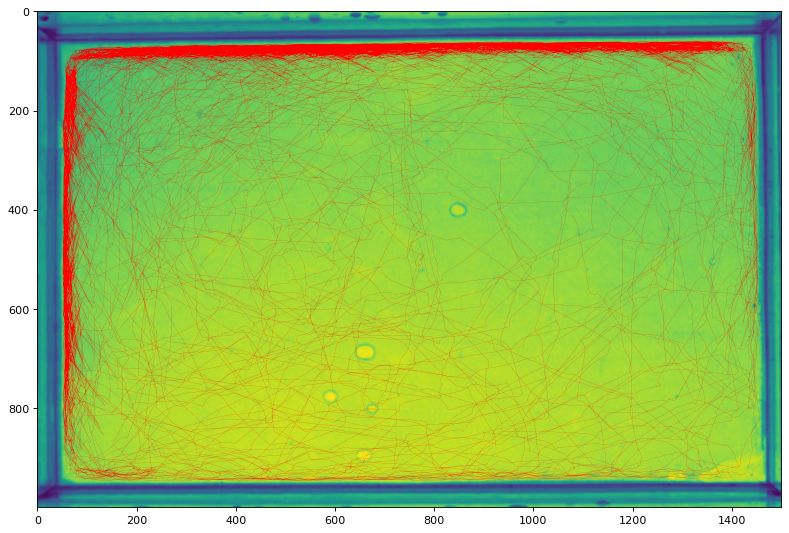

In [72]:
poses = np.array(poses)
h_poses = np.array(h_poses)

plt.figure(figsize=(12, 12), dpi=80)
plt.plot(h_poses[:, 1], h_poses[:, 0], lw = 0.1, c='r')
plt.imshow(background)
velocity = (h_poses[1:]-h_poses[:-1])

In [79]:

cv2_shape = (background.shape[1]//3, background.shape[0]//3)
cv2_shape = (int(cv2_shape[0]), int(cv2_shape[1]))

video = cv2.VideoWriter("free_swim.avi", cv2.VideoWriter_fourcc(*"MJPG"), 20, cv2_shape, True)

for s in tqdm(range(data_len)):
    img = np.load(os.path.join(imgspath, flist[s]))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    img = cv2.circle(img, tuple(h_poses[s,::-1]), 4, (0, 0, 200), -1)
    img = cv2.putText(img, f"{s}", (60,60), cv2.FONT_HERSHEY_COMPLEX_SMALL, 4, (200,200,200), 4)
    img = cv2.resize(img, cv2_shape)
    video.write(cv2.resize(img, cv2_shape))

video.release()

  0%|          | 0/60000 [00:00<?, ?it/s]

KeyboardInterrupt: 

找出"因為太接近邊緣而導致的頭尾翻轉"

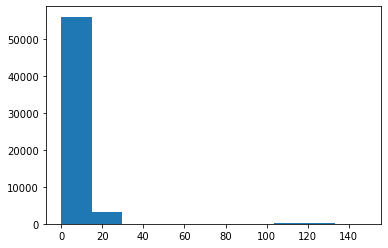

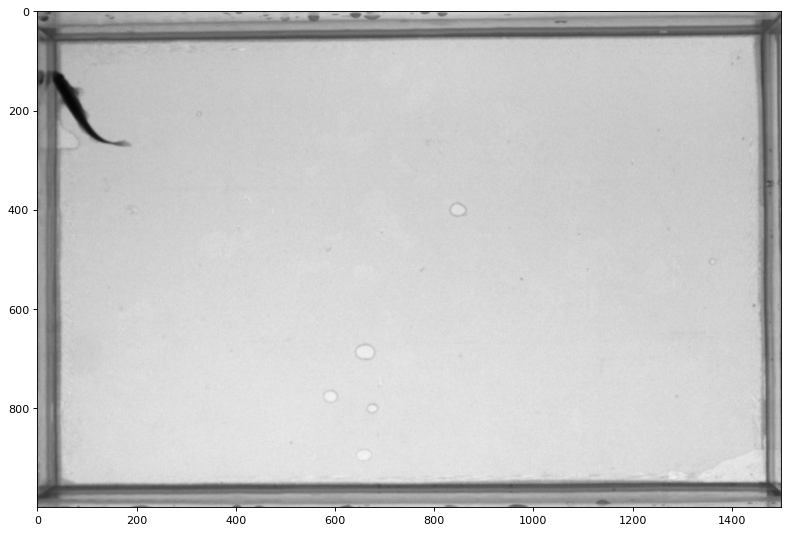

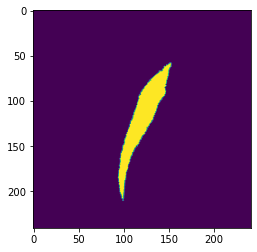

In [510]:
plt.hist(np.linalg.norm(velocity, axis=1))

for s, v in enumerate(np.linalg.norm(velocity, axis=1)):
    if v > 50:
        img = np.load(os.path.join(imgspath, flist[s]))
        break

plt.figure(figsize=(12, 12), dpi=80)        
plt.imshow(img, plt.cm.gray)
plt.show()
plt.imshow(imgs[s+1])

設定邊界

22960


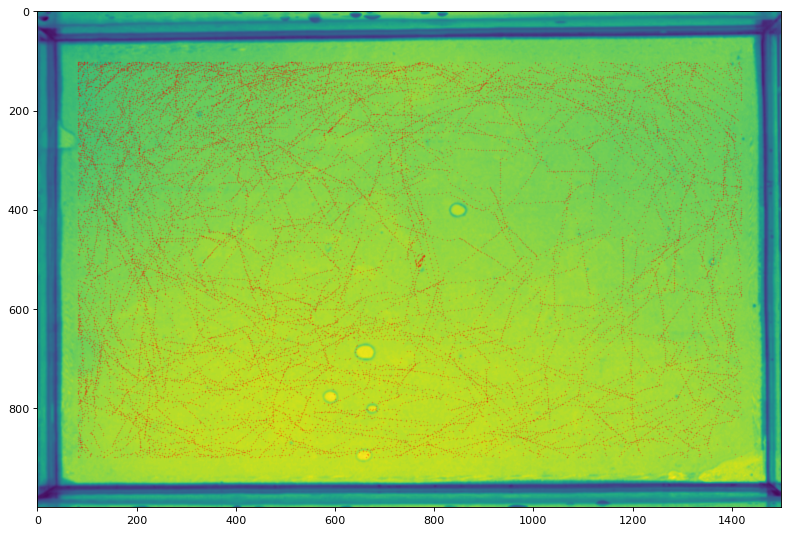

In [59]:
flips = list()
for s in range(len(poses)):
    pos = h_poses[s]
    if pos[0] > 100 and pos[0] < 900 and pos[1] > 80 and pos[1] <1420:
        flips.append(s)
flips = np.array(flips)
plt.figure(figsize=(12, 12), dpi=80)
plt.scatter(h_poses[flips, 1], h_poses[flips, 0], s = 0.01, c='r')
plt.imshow(background)
print(len(flips))

In [56]:

cv2_shape = (background.shape[1]//3, background.shape[0]//3)
cv2_shape = (int(cv2_shape[0]), int(cv2_shape[1]))

video = cv2.VideoWriter("free_swim.avi", cv2.VideoWriter_fourcc(*"MJPG"), 30, cv2_shape, True)

for s in tqdm(range(data_len)):
    img = np.load(os.path.join(imgspath, flist[s]))
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    if s in temp:
        img = cv2.circle(img, tuple(h_poses[s,::-1]), 4, (0, 0, 200), -1)
    img = cv2.putText(img, f"{s}", (60,60), cv2.FONT_HERSHEY_COMPLEX_SMALL, 4, (200,200,200), 4)
    img = cv2.resize(img, cv2_shape)
    video.write(cv2.resize(img, cv2_shape))

video.release()

  0%|          | 0/60000 [00:00<?, ?it/s]

連續超過10frame才能用於作為simple

連續定義：在邊界中且前後沒有發生頭尾翻轉

 total sample numbers: 22352


(array([0., 0., 0., 0., 0., 1., 5., 5., 2., 6., 1., 5., 7., 8., 2., 1., 1.,
        3., 6., 1., 2., 3., 6., 7.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48]),
 <BarContainer object of 24 artists>)

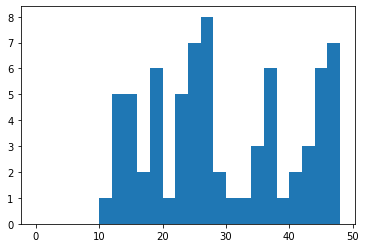

In [102]:
train_sqs = []
last_pos = h_poses[0]
sqen = []

for s in range(data_len-2):
    h_pos = h_poses[s]
    if h_pos[0] > 100 and h_pos[0] < 900 and h_pos[1] > 80 and h_pos[1] <1420 and np.linalg.norm(h_pos-last_pos)<40:
        sqen.append(s)
        pass
    else:
        if len(sqen) > 10:
            train_sqs.append(sqen)
        sqen = []
        pass
    last_pos = h_pos
print(" total sample numbers:", np.sum([len(sq) for sq in train_sqs]))
plt.hist([len(sq) for sq in train_sqs], bins=np.arange(0, 50, 2))

## cal the velocity and acceleration

In [378]:
velocity = (h_poses[1:]-h_poses[:-1])

# do the kernel: [0.25, 0.5, 0.25]

def kernel_method(arr: np.ndarray, kernel = [0.3, 0.4, 0.3]):
    
    if arr.ndim == 1:
        win_shape = (len(kernel))
    else:
        win_shape = list(arr.shape)
        win_shape[0] = len(kernel)
    
    l = len(kernel)//2
    for s in range(len(arr)):
        start = s-l
        end = s+l+1
        windows = np.zeros(win_shape)
        if start < 0:
            windows[-start:] = arr[:end]
        elif end > len(arr):
            end = end-len(arr)
            windows[:-end] = arr[start:]
        else:
            windows = arr[start:end]

        arr[s] = np.dot(kernel, windows) 
    return arr


vel_norms = np.linalg.norm(velocity, axis=1)
vel_norms = kernel_method(vel_norms)

acc = vel_norm[1:]-vel_norm[:-1]

vel_ans = []

for s in range(len(velocity)):
    v1 = velocity[s]
    a = v1/np.linalg.norm(v1, ord=2)
    b = np.array([1,0])
    c = a-b
    angle = 2*np.arcsin(np.linalg.norm(c/2))
    
    err = b-np.dot(get_rot_M(-angle), a) 
    b_len = np.linalg.norm(b)
    while np.linalg.norm(err) > b_len*0.1:
        angle=-angle
        err = b-np.dot(get_rot_M(-angle), a)
        
    if angle != angle:
        angle = vel_ans[s-1]
    vel_ans.append(angle)
vel_ans = np.array(vel_ans)
vel_ans = kernel_method(vel_ans)


acc_ans = vel_ans[1:]-vel_ans[:-1]

<ipython-input-378-83bc88605338>:39: RuntimeWarning: invalid value encountered in true_divide
  a = v1/np.linalg.norm(v1, ord=2)


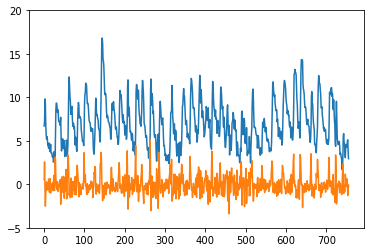

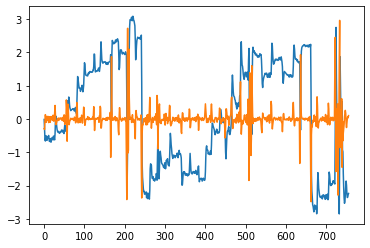

In [386]:
s = np.random.randint(len(train_sqs))
plt.plot(vel_norms[train_sqs[s]])
plt.plot(acc[train_sqs[s]])
plt.ylim([-5,20])
plt.show()

plt.plot(vel_ans[train_sqs[s]])
plt.plot(acc_ans[train_sqs[s]])

(-2.644354567305991, 2.6920403689344115)

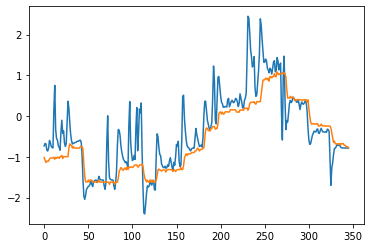

In [387]:
s = np.random.randint(len(train_sqs))

plt.plot(vel_ans[train_sqs[s]])
plt.plot(np.array(h_ans)[train_sqs[s]])
plt.ylim()

## load the PCA and kmeans

In [165]:
import pickle as pk
with open("sideview_pca.pkl", "rb") as file:
    pca = pk.load(file)
with open("side_pos_kmeans.pkl", "rb") as file:
    pos_kmeans = pk.load(file)


[0.85445098 0.09043393 0.02239653] 0.9672814506329379


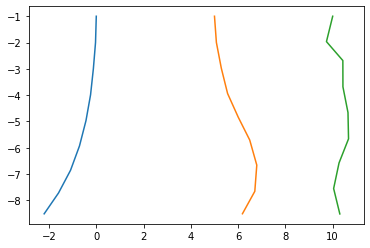

In [166]:
#show the PCA
pc1 = pca.components_[0]
u = np.array([0,-1])
n=0
for pcs in pca.components_:
    sk = [u]
    pcs = pcs*1
    for an in pcs:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M, sk[0]))
    sk = np.array(sk)
    plt.plot(sk[:,0]+n*5,sk[:,1])
    n+=1
print(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

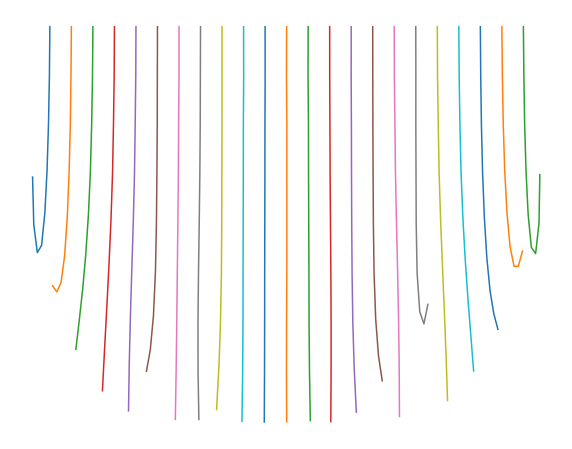

In [167]:
#show the kmeans
centers = pos_kmeans.cluster_centers_

temp = []
for pcas in centers:
    sks = np.dot(pcas, pca.components_)
    sk = [np.array([0,-2])]
    for an in sks:
        M = get_rot_M(an).T
        sk.append(sk[-1]+np.dot(M,u))
    temp.append(np.average(sks, weights=np.abs(len(sks)-0.5-np.arange(len(sks)))))
ords = np.argsort(temp)

plt.figure(figsize=(10,8))
for s, pcas in enumerate(centers[ords]):
    sks = np.dot(pcas, pca.components_)
    sk=[np.array([0,-1])]
    for an in sks:
        M = get_rot_M(an)
        sk.append(sk[-1]+np.dot(M, sk[0]))
    sk = np.array(sk)
    plt.plot(sk[:,0]+s*5,sk[:,1])
    n+=1
plt.axis('off')
plt.show()

In [109]:
def an2vec(an, r):
    x = np.cos(an)
    y = np.sin(an)
    return r*np.array([x,y])

def get_rot_M(angle):
    a = np.cos(angle)
    b = np.sin(angle)
    return np.array([[a,-b],[b,a]])

def an2ori(an_sk, vec=np.array([0,1]), intens=1):
    test_sk = [vec]
    for i in range(len(an_sk)):
        vec = np.dot(vec,get_rot_M(an_sk[i]*intens))
        test_sk.append(test_sk[-1]+vec)

    return np.array(test_sk)


han_sks=[]

for s, img in enumerate(tqdm(imgs)):
    
    sk = NT_skeleton(img, er_num=2, di_num=3)
    
    vec_sk = []
    for i in range(len(sk)-1):
        vec_sk.append(sk[i+1]-sk[i])
    if len(sk)<10:
        plt.imshow(imgs[s])
        print("sk error")
        print(s, NT_skeleton(imgs[s]))
        plt.show()
        break
    
    heading = vec_sk[0]
    han_sk=[]
    
    heading = heading/np.linalg.norm(heading)
    for vec in vec_sk[1:]:
        vec = vec/np.linalg.norm(vec)
        a = heading
        b = vec

        #根據和角公式 = sin(a-b) = sina cosb - cosa sinb
        #sin(angle) = a[1]b[0]-a[0]b[1]
        c = a-b
        angle = 2*np.arcsin(np.linalg.norm(c/2))
        if angle != angle:
            print("算錯啦")
            print(s, vec_sk)
            break
        err = b-np.dot(get_rot_M(angle), a)
        b_len = np.linalg.norm(b)
        while np.linalg.norm(err) > b_len*0.1:
            angle=-angle
            err = b-np.dot(get_rot_M(angle), a)
        
        han_sk.append(angle)
    han_sks.append(np.array(han_sk))
print(len(han_sks))    

## 20000張 1:25

  0%|          | 0/60000 [00:00<?, ?it/s]

60000


In [110]:
pca_sks = pca.transform(han_sks)
labels = pos_kmeans.predict(pca_sks)
centers = pos_kmeans.cluster_centers_

# tensorflow (CNN)

In [237]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.4.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## genrate the data for training

The model use last 10 frames to predict the current acceleration, each frame contain the posural label and velocity vector

The shape of input_data is (None, 30), and the output is (None, 2)

In [463]:
input_data, output_data = [], []

for sq in train_sqs:
    sq_labels = labels[sq]
    sq_vel_ans = vel_ans[sq]
    sq_vel_norms = vel_norms[sq]
    for s in range(len(sq)):
        if s>=9:
            temp = list(sq_labels[s-9:s+1])
            #temp.extend(sq_vel_ans[s-9:s+1])
            #temp.extend(sq_vel_norms[s-9:s+1])
            input_data.append(temp)
            output_data.append([acc_ans[s]])
            
input_data = np.array(input_data)
output_data = np.array(output_data)
print(f"the total sample after regenerate : {len(output_data)}")

s = np.random.randint(len(input_data))
print(f"input :{input_data[s]} \noutput:{output_data[s]}")

the total sample after regenerate : 20723
input :[21 21  1  1  8  1 21 21  1  1] 
output:[0.28833833]


## bulid the model

In [464]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(len(input_data[0]),)),
    layers.Dense(units=40),
    layers.Dense(units=10),
    layers.Dense(units=1),    
])

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 40)                440       
_________________________________________________________________
dense_67 (Dense)             (None, 10)                410       
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 11        
Total params: 861
Trainable params: 861
Non-trainable params: 0
_________________________________________________________________


In [468]:
batchsize = 512
N_epochs = 100

data_len = len(input_data)
train_len = int(data_len*0.8)
val_len = data_len-train_len

steps_per_epoch = train_len//batchsize + 1

indexes = np.arange(data_len)
np.random.shuffle(indexes)

train_indexes = indexes[:train_len]
val_indexes = indexes[train_len:]
            
def generate_arrays_from_ram_to_data(train_indexes, batchsize):
    indexes = train_indexes
    np.random.shuffle(indexes)
    
    batch_start = 0
    temp_index = indexes[batch_start:batch_start+batchsize]
    
    inp = input_data[temp_index]
    outp = output_data[temp_index]
    
    while True:
        yield (inp, outp)
        batch_start += batchsize
        if batch_start+batchsize > len(indexes):
            np.random.shuffle(indexes)
            batch_start = 0
        
        temp_index = indexes[batch_start:batch_start+batchsize]
        inp = input_data[temp_index]
        outp = output_data[temp_index]

In [469]:
for x in generate_arrays_from_ram_to_data(train_indexes, 100):
    print(x[0].shape)
    print(x[1].shape)
    break

(100, 10)
(100, 1)


In [470]:
import time
start = time.localtime()
adam_tune=keras.optimizers.Adam(lr=0.001)
opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model.compile(loss='mean_squared_error', optimizer=adam_tune)
history = model.fit(generate_arrays_from_ram_to_data(train_indexes, batchsize=batchsize)
          , steps_per_epoch=steps_per_epoch, epochs=N_epochs,
            validation_data=(input_data[val_indexes], output_data[val_indexes]), verbose=1)

Epoch 1/100
33/33 [==============================] - 0s 5ms/step - loss: 1.0365 - val_loss: 1.0039
Epoch 2/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9654 - val_loss: 1.0092
Epoch 3/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0031 - val_loss: 1.0074
Epoch 4/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9614 - val_loss: 1.0103
Epoch 5/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9994 - val_loss: 1.0183
Epoch 6/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9992 - val_loss: 1.0137
Epoch 7/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9704 - val_loss: 1.0289
Epoch 8/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9860 - val_loss: 1.0061
Epoch 9/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9746 - val_loss: 1.0104
Epoch 10/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9811 - val_loss: 1.0085
Epoch 11/

33/33 [==============================] - 0s 4ms/step - loss: 1.0119 - val_loss: 1.0048
Epoch 84/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9800 - val_loss: 1.0075
Epoch 85/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9718 - val_loss: 1.0134
Epoch 86/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9965 - val_loss: 1.0203
Epoch 87/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9855 - val_loss: 1.0097
Epoch 88/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0142 - val_loss: 1.0127
Epoch 89/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0254 - val_loss: 1.0074
Epoch 90/100
33/33 [==============================] - 0s 4ms/step - loss: 0.9578 - val_loss: 1.0039
Epoch 91/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0009 - val_loss: 1.0063
Epoch 92/100
33/33 [==============================] - 0s 4ms/step - loss: 1.0052 - val_loss: 1.0079
Epoch 93/100


In [ ]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

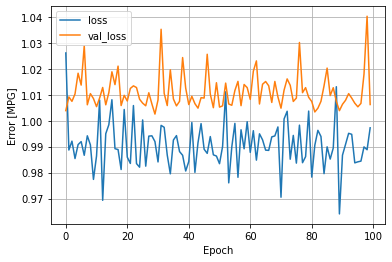

In [471]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

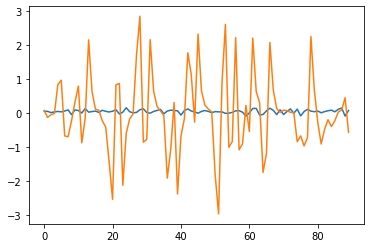

In [472]:


temp = model.predict(input_data[10:100])
plt.plot(temp[:])
plt.plot(output_data[10:100])

# try the one hot encode

In [488]:
input_data, output_data = [], []

for sq in train_sqs:
    sq_labels = labels[sq]
    sq_vel_ans = vel_ans[sq]
    sq_vel_norms = vel_norms[sq]
    for s in range(len(sq)):
        if s>=9:
            temp = tf.one_hot(sq_labels[s-9:s+1], pos_kmeans.n_clusters)
            #temp = sq_labels[s-9:s+1]
            input_data.append(temp)
            output_data.append([acc[s]])
            
input_data = np.array(input_data)
output_data = np.array(output_data)
print(f"the total sample after regenerate : {len(output_data)}")

s = np.random.randint(len(input_data))
print(f"input :{input_data[s]} \noutput:{output_data[s]}")

the total sample after regenerate : 20723
input :[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]] 
output:[-1.89867623]


## build the model

In [490]:
model_hot = tf.keras.Sequential([
    tf.keras.Input(shape=input_data[0].shape),
    layers.Conv1D(32, 5, activation='tanh'),
    layers.Flatten(),
    layers.Dense(units=50),
    layers.Dense(units=1),    
])

model_hot.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 6, 32)             3712      
_________________________________________________________________
flatten_4 (Flatten)          (None, 192)               0         
_________________________________________________________________
dense_87 (Dense)             (None, 50)                9650      
_________________________________________________________________
dense_88 (Dense)             (None, 1)                 51        
Total params: 13,413
Trainable params: 13,413
Non-trainable params: 0
_________________________________________________________________


In [491]:
batchsize = 512
N_epochs = 100

data_len = len(input_data)
train_len = int(data_len*0.8)
val_len = data_len-train_len

steps_per_epoch = train_len//batchsize + 1

indexes = np.arange(data_len)
np.random.shuffle(indexes)

train_indexes = indexes[:train_len]
val_indexes = indexes[train_len:]
            
def generate_arrays_from_ram_to_data(train_indexes, batchsize):
    indexes = train_indexes
    np.random.shuffle(indexes)
    
    batch_start = 0
    temp_index = indexes[batch_start:batch_start+batchsize]
    
    inp = input_data[temp_index]
    outp = output_data[temp_index]
    
    while True:
        yield (inp, outp)
        batch_start += batchsize
        if batch_start+batchsize > len(indexes):
            np.random.shuffle(indexes)
            batch_start = 0
        
        temp_index = indexes[batch_start:batch_start+batchsize]
        inp = input_data[temp_index]
        outp = output_data[temp_index]
for x in generate_arrays_from_ram_to_data(train_indexes, 100):
    print(x[0].shape)
    print(x[1].shape)
    break

(100, 10, 23)
(100, 1)


In [492]:
import time
adam_tune=keras.optimizers.Adam(lr=0.001)
opt = tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
model_hot.compile(loss='mean_squared_error', optimizer=adam_tune)
history = model_hot.fit(generate_arrays_from_ram_to_data(train_indexes, batchsize=batchsize)
          , steps_per_epoch=steps_per_epoch, epochs=N_epochs,
            validation_data=(input_data[val_indexes], output_data[val_indexes]), verbose=1)

Epoch 1/100
33/33 [==============================] - 13s 212ms/step - loss: 59.1503 - val_loss: 58.6258
Epoch 2/100
33/33 [==============================] - 0s 11ms/step - loss: 52.7459 - val_loss: 58.7545
Epoch 3/100
33/33 [==============================] - 0s 14ms/step - loss: 59.3092 - val_loss: 58.7552
Epoch 4/100
33/33 [==============================] - 0s 15ms/step - loss: 52.3690 - val_loss: 58.7890
Epoch 5/100
33/33 [==============================] - 0s 12ms/step - loss: 55.3736 - val_loss: 58.8263
Epoch 6/100
33/33 [==============================] - 0s 14ms/step - loss: 57.1092 - val_loss: 58.8374
Epoch 7/100
33/33 [==============================] - 0s 9ms/step - loss: 57.5554 - val_loss: 58.8378
Epoch 8/100
33/33 [==============================] - 0s 5ms/step - loss: 56.5436 - val_loss: 58.9387
Epoch 9/100
33/33 [==============================] - 0s 5ms/step - loss: 53.1146 - val_loss: 58.9728
Epoch 10/100
33/33 [==============================] - 0s 7ms/step - loss: 58.5873 -

Epoch 81/100
33/33 [==============================] - 0s 13ms/step - loss: 56.8979 - val_loss: 59.1318
Epoch 82/100
33/33 [==============================] - 0s 14ms/step - loss: 52.7712 - val_loss: 59.1489
Epoch 83/100
33/33 [==============================] - 0s 12ms/step - loss: 51.7375 - val_loss: 59.1644
Epoch 84/100
33/33 [==============================] - 0s 15ms/step - loss: 57.5139 - val_loss: 59.1722
Epoch 85/100
33/33 [==============================] - 0s 12ms/step - loss: 52.6945 - val_loss: 59.1638
Epoch 86/100
33/33 [==============================] - 0s 15ms/step - loss: 55.4890 - val_loss: 59.1513
Epoch 87/100
33/33 [==============================] - 0s 13ms/step - loss: 58.8501 - val_loss: 59.1609
Epoch 88/100
33/33 [==============================] - 0s 9ms/step - loss: 50.0207 - val_loss: 59.2054
Epoch 89/100
33/33 [==============================] - 0s 12ms/step - loss: 51.7782 - val_loss: 59.1715
Epoch 90/100
33/33 [==============================] - 0s 13ms/step - loss:

# generate the sq from markov

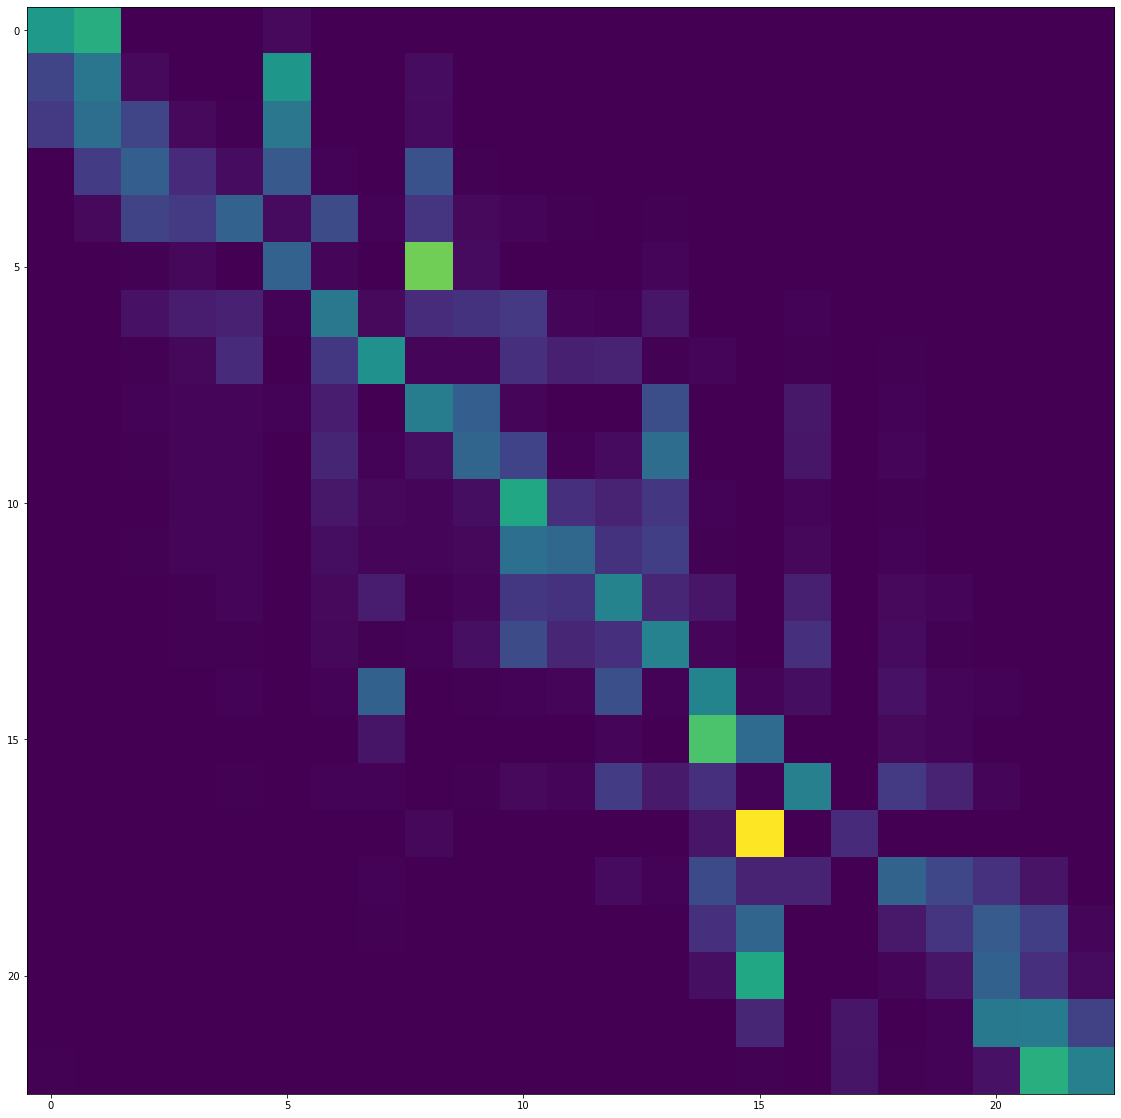

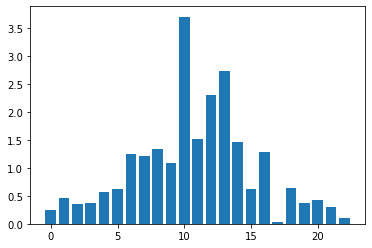

In [397]:
MK = np.zeros((pos_kmeans.n_clusters, pos_kmeans.n_clusters))
for s in range(1, len(labels)):
    label_now = labels[s]
    label_last = labels[s-1]
    
    MK[label_last, label_now] += 1
for s in range(pos_kmeans.n_clusters):
    MK[s, :] = MK[s, :]/np.sum(MK[s, :])

for s in range(pos_kmeans.n_clusters):
    MK[s, :] = MK[s, ords]

for s in range(pos_kmeans.n_clusters):
    MK[:, s] = MK[ords, s]

plt.figure(figsize=(20,20))
plt.imshow(MK[:,:])
arr = [0]*23
arr[0] = 1
plt.show()

u = [1]*23

for s in range(1000):
    u = np.dot(np.array(u), MK)

plt.bar(np.arange(23), u)
plt.show()